### Plot Config

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
colors = ['#1e88e5', '#ff0d57', '#13b755']
mpl.rcParams.update({
    'axes.prop_cycle': mpl.cycler('color', colors),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Load Libraries

In [4]:
import numpy as np
import jax.numpy as npx
import scipy.optimize as optim

In [5]:
import solutions_ps4 as sol

### Question 1

In [6]:
# algo params
ptol = 1e-4 # perturb offset
N1 = 512 # grid size
s_klo, s_khi = 0.01, 2.0 # grid range

In [7]:
# model parameters
ρ = 0.05 # discount rate
n = 0.02 # population growth
α = 0.35 # capital elasticity
δ = 0.1 # depreciation

In [8]:
# useful functions
f = lambda k: k**α
fp = lambda k: α*k**(α-1)
fpi = lambda r: (α/r)**(1/(1-α))
fk_1 = lambda k, c: f(k)/k - (δ+n) - c/k

In [9]:
# steady state
kss_1 = fpi(ρ+δ)
css_1 = f(kss_1) - (δ+n)*kss_1
print(kss_1, css_1)

3.6822912099066776 1.1362498590569179


In [10]:
# kgrid limits
klo_1, khi_1 = s_klo*kss_1, s_khi*kss_1
kgrid_1 = np.linspace(klo_1, khi_1, N1)
klim_1 = {'k_lo': klo_1, 'k_hi': khi_1}

In [11]:
# get stable arm
fc_1 = lambda k, c: fp(k) - (ρ+δ)
cpol_1 = sol.ramsey_policy(kss_1, css_1, fk_1, fc_1, **klim_1)

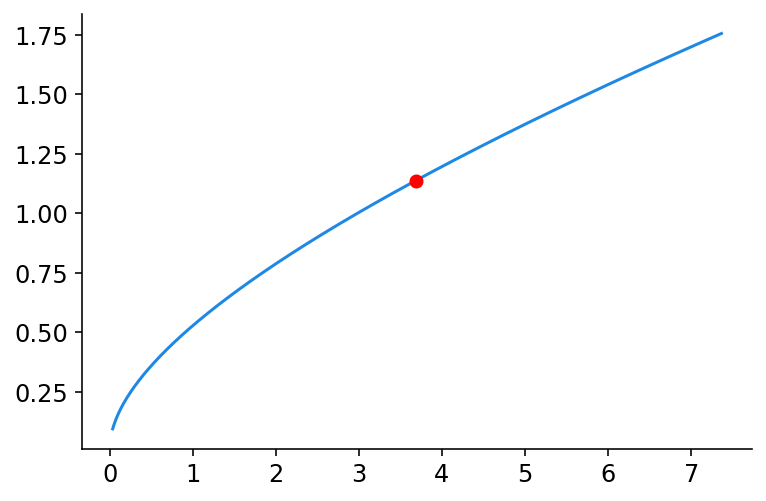

In [12]:
# plot results
fig, ax = plt.subplots()
ax.plot(kgrid_1, cpol_1(kgrid_1))
ax.scatter([kss_1], [css_1], c='r', zorder=10);

### 1(a)

Here we simply jump up onto the new stable arm and follow that to steady state.

In [13]:
# capital tax
τk = 0.3

In [14]:
# new steady state
kss_1a = fpi(δ+ρ/(1-τk))
css_1a = f(kss_1a) - (δ+n)*kss_1a
print(kss_1a, css_1a)

2.9984702984154143 1.108822077699741


In [15]:
# get new stable arm
fc_1a = lambda k, c: (1-τk)*(fp(k)-δ) - ρ
cpol_1a = sol.ramsey_policy(kss_1a, css_1a, fk_1, fc_1a, **klim_1)

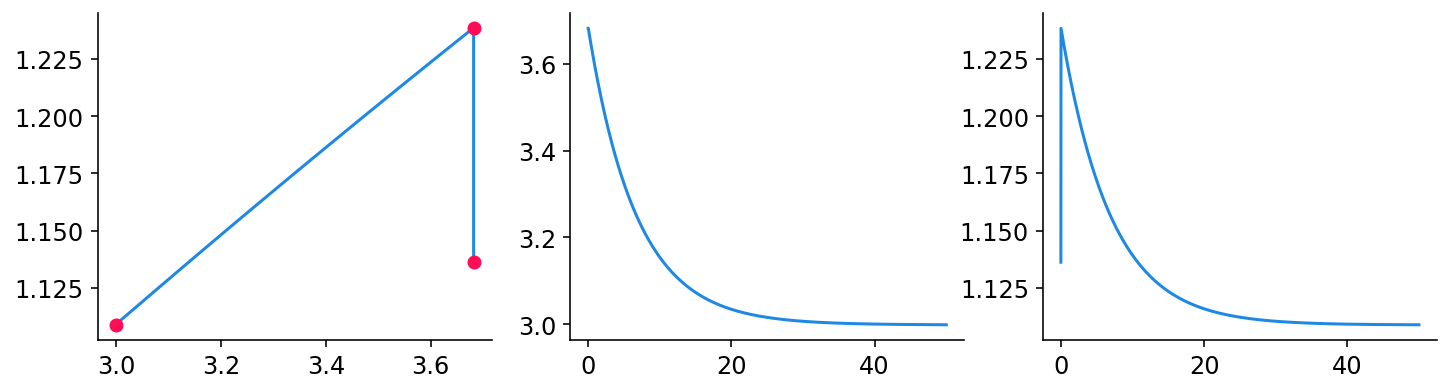

In [16]:
kpath_1a0, cpath_1a0 = sol.ramsey_forward(kss_1, cpol_1a, fk_1, S=5000)
kpath_1a = np.concatenate([[kss_1], kpath_1a0])
cpath_1a = np.concatenate([[css_1], cpath_1a0])
ax0, ax1, ax2 = sol.path_plot(kpath_1a, cpath_1a)
ax0.scatter([kss_1, kss_1a, kss_1], [css_1, css_1a, cpol_1a(kss_1)], c=colors[1], zorder=10);

### 1(b)

This requires solving for an intersection. One way is to choose the consumption level that we jump to on announcement so that we end up on the new stable arm after one year. Another, potentially more stable way, is to choose the capital level after one year so that when we go backwards in time one year, we are at the original capital level. Here we use the second approach.

In [17]:
# find intercept point
def intercept_1b(k1):
    c1 = cpol_1a(k1)
    k0, c0 = sol.ramsey_simulate(k1, c1, fk_1, fc_1, path=False, t0=1, t_min=0, gk_targ=1e-4, **klim_1)
    return k0, c0
def obj_1b(k1):
    k0, c0 = intercept_1b(k1)
    return k0 - kss_1

In [18]:
k1yr_1b = optim.root_scalar(obj_1b, bracket=(kss_1a, kss_1)).root
c1yr_1b = cpol_1a(k1yr_1b)
k0yr_1b, c0yr_1b = intercept_1b(k1yr_1b)
print(k1yr_1b, c1yr_1b)
print(k0yr_1b, c0yr_1b)

3.5953320983361605 1.2224972172324642
3.6822912099067113 1.221072099581363


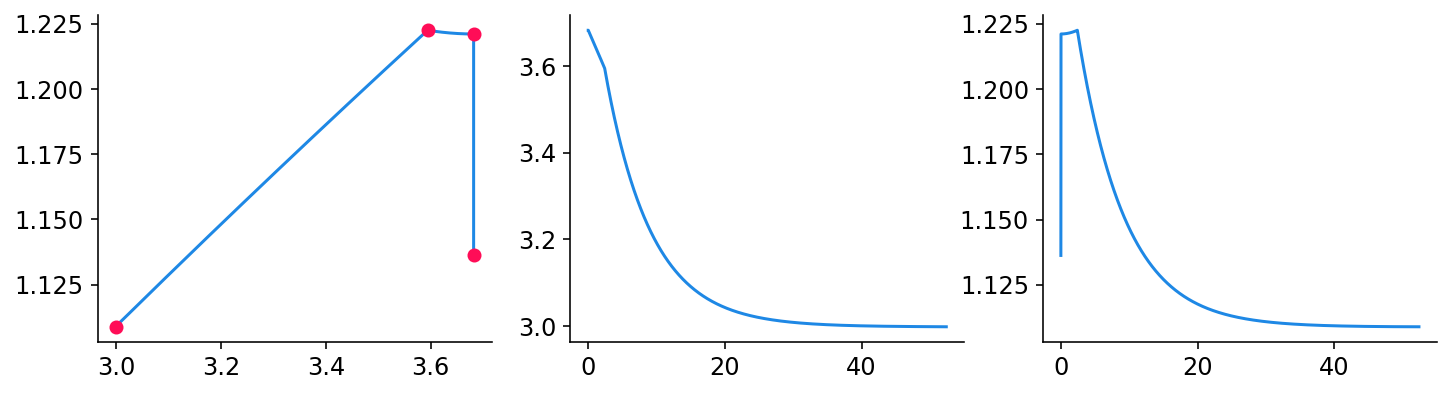

In [19]:
# get forward path
kpath_1b0, cpath_1b0 = sol.ramsey_simulate(
    k0yr_1b, c0yr_1b, fk_1, fc_1, t_max=1, direc=1, gk_targ=1e-4, **klim_1
)
kpath_1b1, cpath_1b1 = sol.ramsey_forward(k1yr_1b, cpol_1a, fk_1, S=5000)
kpath_1b = np.concatenate([[kss_1], kpath_1b0, kpath_1b1])
cpath_1b = np.concatenate([[css_1], cpath_1b0, cpath_1b1])
ax0, ax1, ax2 = sol.path_plot(kpath_1b, cpath_1b)
ax0.scatter([kss_1, k0yr_1b, k1yr_1b, kss_1a], [css_1, c0yr_1b, c1yr_1b, css_1a], c=colors[1], zorder=10);

### 1(c)

Because the state valuation $\mu$ should be continuous in time, we must have the following conditions immediately before and after the policy change ($t=1$)

$$ u^{\prime}(c_-) = \mu \qquad \text{and} \qquad u^{\prime}(c_+) = (1+\tau) \mu $$

Combining these and noting that we have $\log$ utility, we arrive at an equation characterizing the consumption jump that occurs at $t=1$

$$ \frac{c_+}{c_-} = \frac{1}{1+\tau} $$

Thus we want to choose the capital level after one year ($k_1$) so that when we go backwards in time from $(k_1, (1+\tau) c^{\ast}(k_1))$, we end up at our initial capital level. After that point, we simply follow the same stable arm back to the original steady state.

In [20]:
# consumption tax
τc = 0.3

In [21]:
# find intercept point
def intercept_1c(k1):
    c1 = (1+τc)*cpol_1(k1)
    k0, c0 = sol.ramsey_simulate(k1, c1, fk_1, fc_1, path=False, t0=1, t_min=0, gk_targ=1e-4, **klim_1)
    return k0, c0
def obj_1c(k1):
    k0, c0 = intercept_1c(k1)
    return k0 - kss_1

In [22]:
k1yr_1c = optim.root_scalar(obj_1c, bracket=(kss_1, klo_1)).root
c1yr1_1c = cpol_1(k1yr_1c)
c1yr0_1c = (1+τc)*c1yr1_1c
k0yr_1c, c0yr_1c = intercept_1c(k1yr_1c)
print(k1yr_1c, c1yr0_1c, c1yr1_1c)
print(k0yr_1c, c0yr_1c)

3.4083865763746877 1.4089821049845306 1.0838323884496388
3.6822912099071963 1.4036980381659214


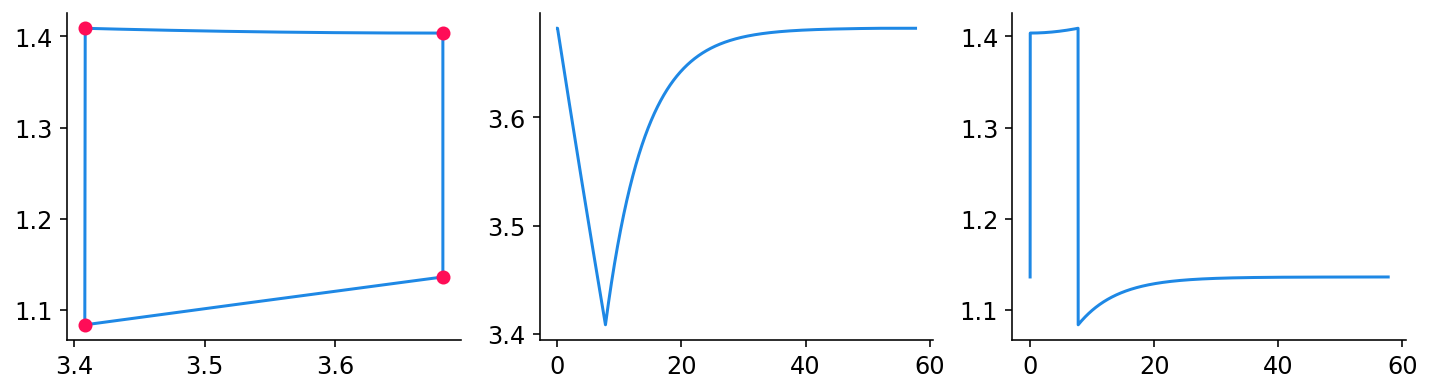

In [23]:
# get forward path
kpath_1c0, cpath_1c0 = sol.ramsey_simulate(
    k0yr_1c, c0yr_1c, fk_1, fc_1, t_max=1, direc=1, gk_targ=1e-4, **klim_1
)
kpath_1c1, cpath_1c1 = sol.ramsey_forward(k1yr_1c, cpol_1, fk_1, S=5000)
kpath_1c = np.concatenate([[kss_1], kpath_1c0, kpath_1c1])
cpath_1c = np.concatenate([[css_1], cpath_1c0, cpath_1c1])
ax0, ax1, ax2 = sol.path_plot(kpath_1c, cpath_1c)
ax0.scatter(
    [kss_1, k0yr_1c, k1yr_1c, k1yr_1c],
    [css_1, c0yr_1c, c1yr0_1c, c1yr1_1c],
    c=colors[1], zorder=10
);

### 1(d)

This is a bit funky. But we basically start from a slightly perturbed steady state and go backwards in time. We want to end up at the original steady state at time zero. But there aren't any real values to solve for. The only wiggle room we have is when to start the simulation (I use $t=20$ below) and how much to perturb it by initially, which we solve for.

In [24]:
fτ = lambda t: τc*(1-np.exp(-t))
dfτ = lambda t: τc*np.exp(-t)
fk_1d = lambda k, c, t: fk_1(k, c)
fc_1d = lambda k, c, t: fp(k) - (ρ+δ) - dfτ(t)/(1+fτ(t))

In [25]:
def intercept_1d(ptol, path=False):
    ktol, ctol = ptol, ptol
    return sol.ramsey_simulate(
        kss_1+ktol, css_1+ctol, fk_1d, fc_1d, t0=20, t_min=0, direc=-1,
        dt_max=0.2, S=10000, t_dep=True, gk_targ=1e-4, path=path, **klim_1
    )
def obj_1d(ptol):
    k0, c0, t0 = intercept_1d(ptol)
    return k0 - kss_1

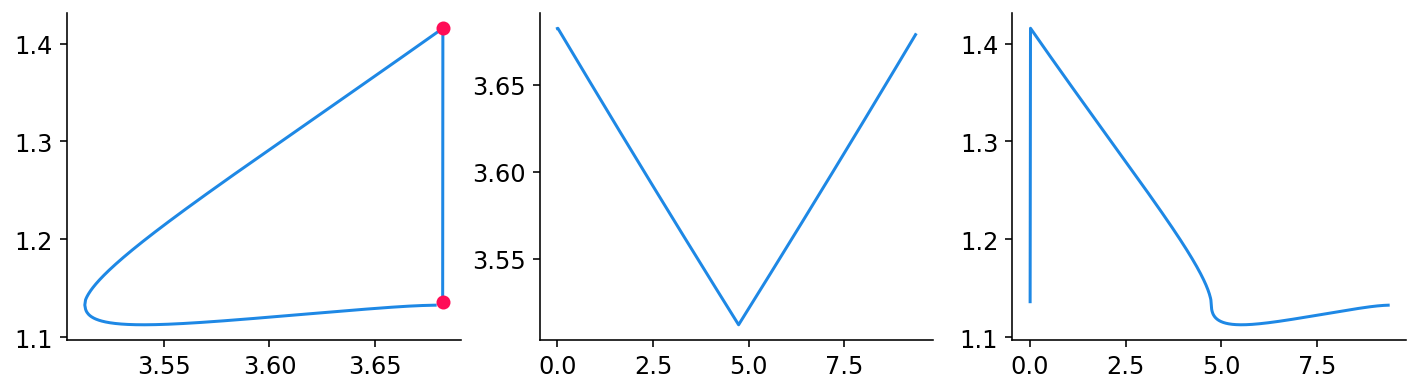

In [26]:
ptol1 = optim.root_scalar(obj_1d, bracket=(-1e-5, -1e-2)).root
k0_1d, c0_1d, t0_1d = intercept_1d(ptol1)
kpath_1d0, cpath_1d0, _ = intercept_1d(ptol1, path=True)
kpath_1d = np.concatenate([[kss_1], kpath_1d0[::-1]])
cpath_1d = np.concatenate([[css_1], cpath_1d0[::-1]])
ax0, ax1, ax2 = sol.path_plot(kpath_1d, cpath_1d)
ax0.scatter([kss_1, kpath_1d0[-1]], [css_1, cpath_1d0[-1]], c=colors[1], zorder=10);

### Question 2

In [27]:
# algo params
N2 = 256 # capital grid size
K2 = 1000 # max number of iterations1
vtol = 1e-12 # convergence criterion

In [28]:
# additional params
β = 0.95

In [29]:
# steady state
kss_2 = fpi(1/β-(1-δ))
css_2 = f(kss_2) - δ*kss_2
print(kss_2, css_2)

3.585072304894327 1.2049077596148596


In [30]:
# grid it up
klo_2, khi_2 = s_klo*kss_2, s_khi*kss_2
kgrid_2 = np.linspace(klo_2, khi_2, N2)
ypgrid_2 = f(kgrid_2) + (1-δ)*kgrid_2
klim_2 = {'k_lo': klo_2, 'k_hi': khi_2}

### 2(a)

In [31]:
val_2a, ipol_2a, verr_2a = sol.vfi_numpy(kgrid_2, ypgrid_2, β)
kpol_2a = kgrid_2[ipol_2a]

0 2.1294151263200622
100 0.000365171452938462
200 2.162008260420123e-06
300 1.280023642635797e-08
400 7.578560001775259e-11
485 converged 9.707790127322369e-13


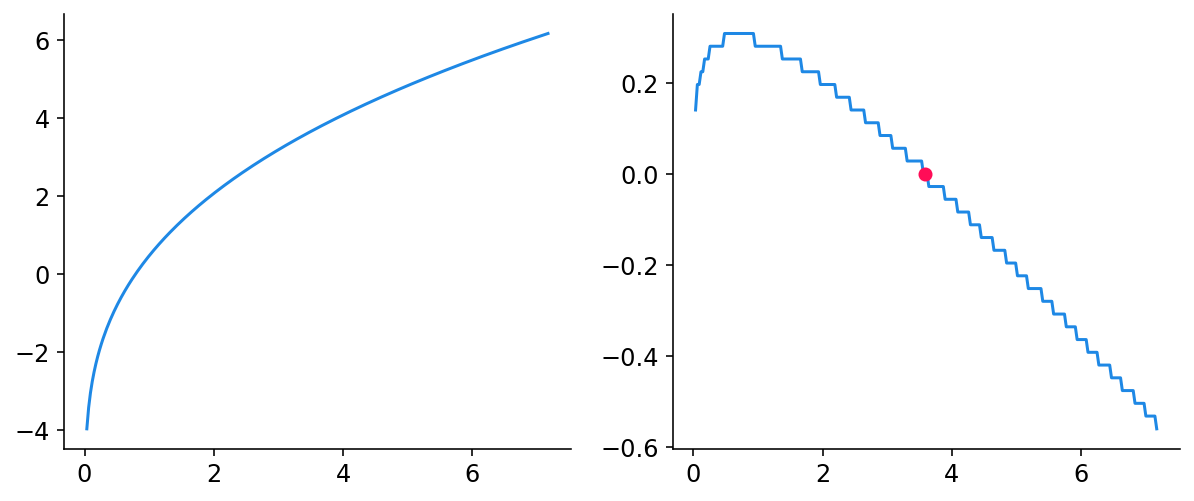

In [32]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
ax0.plot(kgrid_2, val_2a);
ax1.plot(kgrid_2, kpol_2a-kgrid_2)
ax1.scatter(kss_2, 0, c=colors[1], zorder=10);

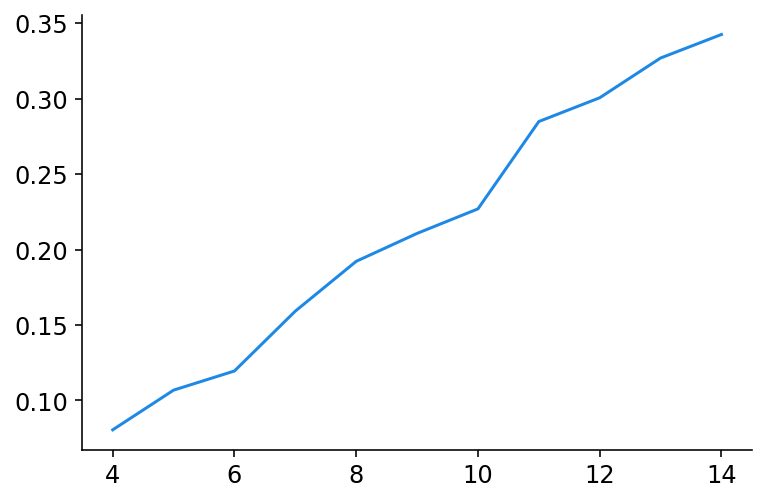

In [33]:
vfunc_2a = lambda vt: sol.vfi_numpy(kgrid_2, ypgrid_2, β, output=False, vtol=vt)
vtols_2a, tdata_2a = sol.profile(vfunc_2a, 4, 15)
plt.plot(-np.log10(vtols_2a), tdata_2a);

### 2(b)

In [34]:
val_2b, ipol_2b, verr_2b = sol.vfi_numpy(kgrid_2, ypgrid_2, β, np1=npx)
kpol_2b = kgrid_2[ipol_2b]

0 2.129415
100 0.00036621094
200 3.33786e-06
280 converged 0.0


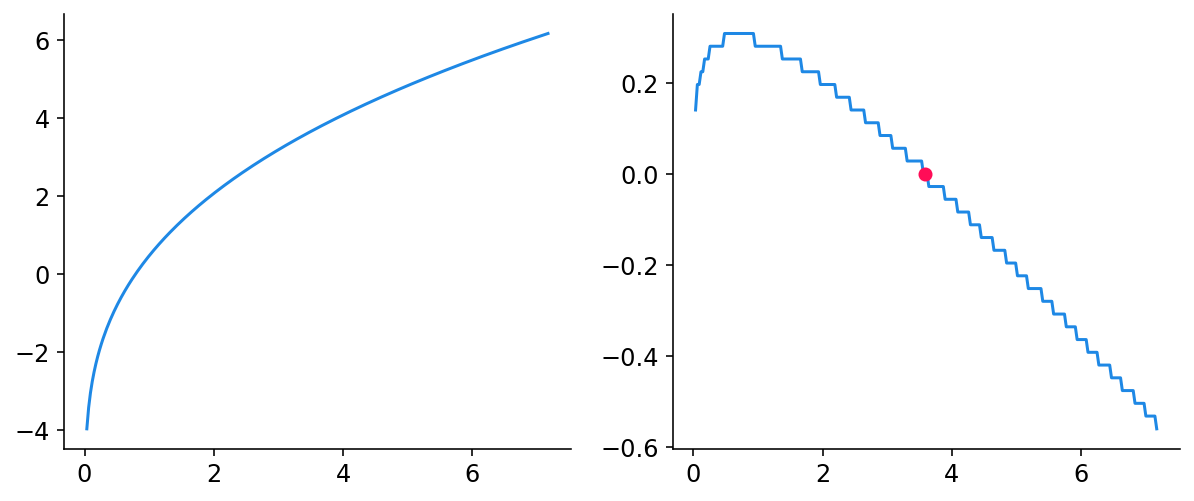

In [35]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
ax0.plot(kgrid_2, val_2b);
ax1.plot(kgrid_2, kpol_2b-kgrid_2)
ax1.scatter(kss_2, 0, c=colors[1], zorder=10);

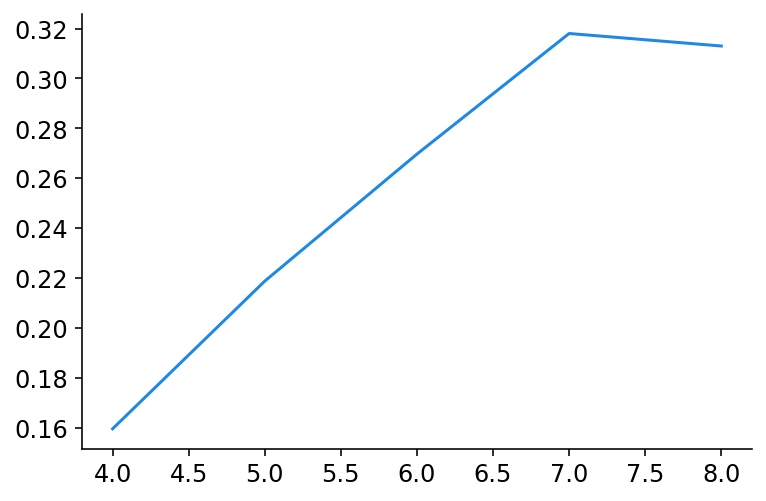

In [36]:
vfunc_2b = lambda vt: sol.vfi_numpy(kgrid_2, ypgrid_2, β, output=False, vtol=vt, np1=npx)
vtols_2b, tdata_2b = sol.profile(vfunc_2b, 4, 9)
plt.plot(-np.log10(vtols_2b), tdata_2b);

### 2(c)

In [37]:
val_2c, kpol_2c, verr_2c = sol.vfi_interp(kgrid_2, ypgrid_2, β, kind='cubic', **klim_2)

0 2.1294151258824803
100 0.00036459896726270813
200 2.1586157386010996e-06
300 1.278015471228855e-08
400 7.567102500161127e-11
485 converged


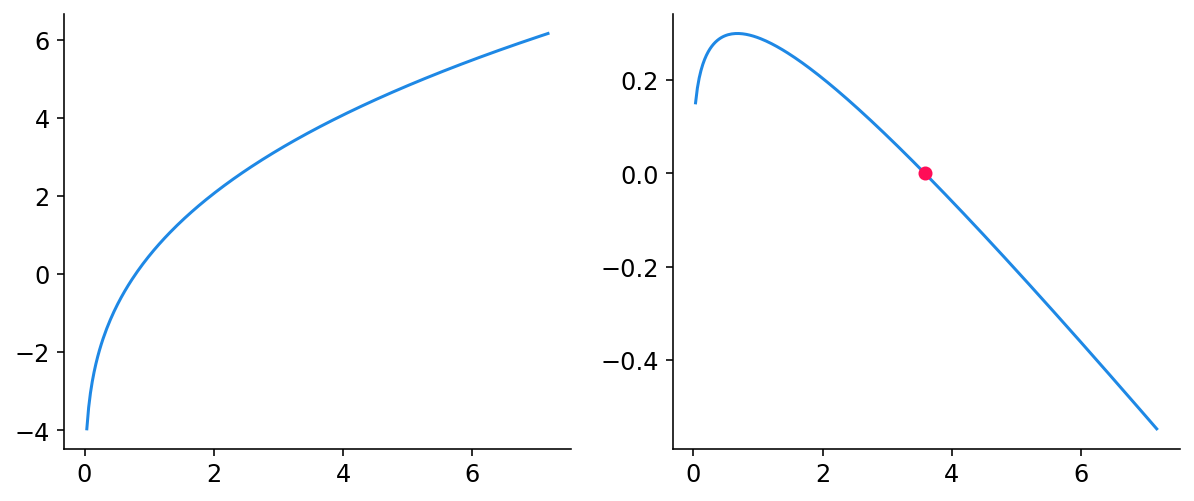

In [38]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
ax0.plot(kgrid_2, val_2c);
ax1.plot(kgrid_2, kpol_2c-kgrid_2)
ax1.scatter(kss_2, 0, c=colors[1], zorder=10);

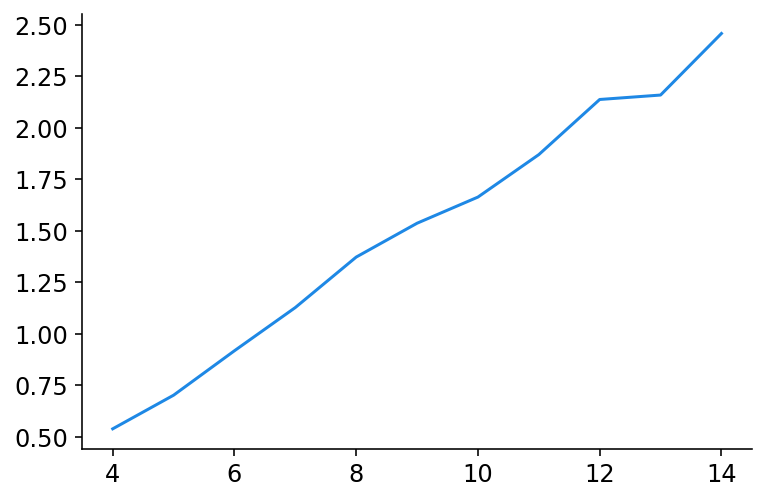

In [39]:
vfunc_2cl = lambda vt: sol.vfi_interp(
    kgrid_2, ypgrid_2, β, kind='cubic', output=False, vtol=vt, **klim_2
)
vtols_2cl, tdata_2cl = sol.profile(vfunc_2cl, 4, 15)
plt.plot(-np.log10(vtols_2cl), tdata_2cl);

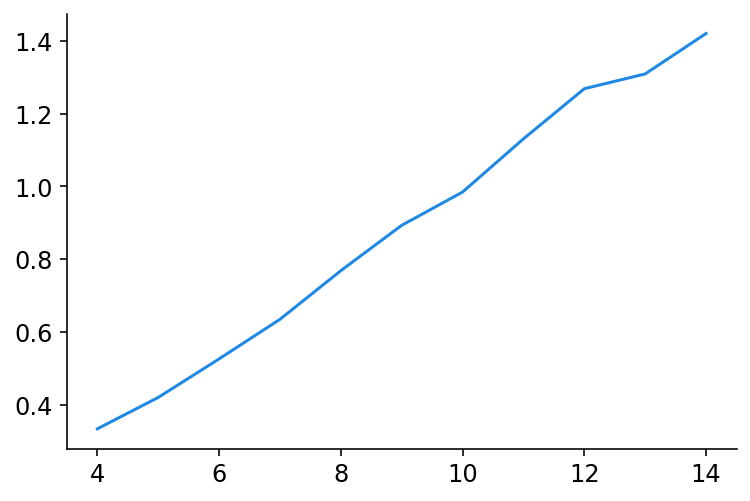

In [40]:
vfunc_2cc = lambda vt: sol.vfi_interp(
    kgrid_2, ypgrid_2, β, kind='linear', output=False, vtol=vt, **klim_2
)
vtols_2cc, tdata_2cc = sol.profile(vfunc_2cc, 4, 15)
plt.plot(-np.log10(vtols_2cc), tdata_2cc);